<a href="https://colab.research.google.com/github/avitalkras/Deep-Learning-Project/blob/main/IDL_TUT_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="padding: 20px; border-radius: 10px; border: 2px solid #3A506B; background-color: #FF8C00; color: #1C2541;">
    <h2 style="font-family: Arial, sans-serif; color: #1C2541; text-align: center; font-size: 1.5em; font-weight: normal;">
        Denoising Autoencoder Code Example
    </h2>
</div>

### In lecture, Noam mentioned Autoencoders can be used to denoise images.


In [ ]:
from IPython.display import Image, display

# Display the image
display(Image(filename='Denoising_AE.png'))

# Imports

In [ ]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Overview

We are going to work with MNIST which contains 60k 28 x 28 images of black and white digits 0 - 9. Our goal is given a noisy image of a digit, we can denoise it. To do this, we are going to take the original image x, add some noise to get x_noise, and then train an autoencoder for a supervised pixel-wise regression problem that given x_noise, the decoder should output the original image without noise, x.

In [ ]:
# Define transformations, only convert data to torch.FloatTensor
transform = transforms.ToTensor()

In [ ]:
# Download the MNIST dataset and apply above transformation
train_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True, download=True, transform=transform) # Define as train
test_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=False, download=True, transform=transform) # Define as test (No HP, so no validation)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.09MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.21MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.5MB/s]


In [ ]:
# How many samples per batch to load
batch_size = 16

# Prepare data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)  # Shuffle training data
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
print(len(train_loader))

3750


## Let's take a closer look on the data set

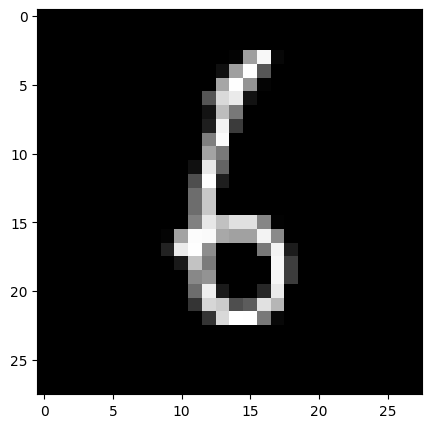

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# get one image from the batch
idx = 5
img = np.squeeze(images[idx])

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

# Define Our Conv Denoiser Model

The ConvDenoiser is a convolutional autoencoder designed to denoise images by learning a compressed representation of the input image and reconstructing it back to its original form. It works in two main stages:

- Encoder Stage: Compresses the image by extracting important features.
- Decoder Stage: Reconstructs the image from the compressed representation, ideally removing noise in the process.

This architecture is common in image denoising tasks, where the network learns to map noisy images to their clean versions.



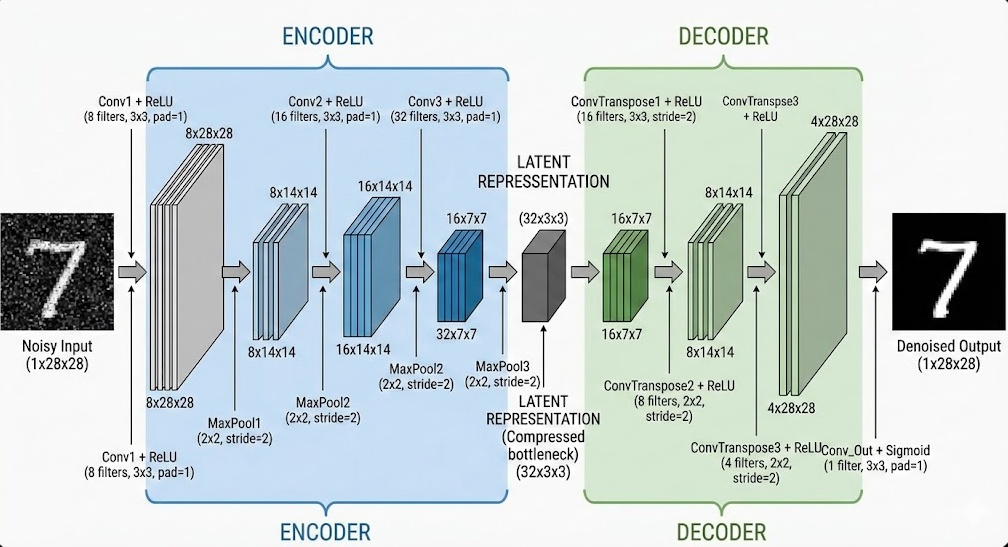

In [ ]:
display(Image(filename='conv_denoiser.png'))
#small error, stride of 1, not 2.

In [ ]:
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        ## encoder layers
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)  # Conv layer (channels from 1 --> 8), 3x3 kernels
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)  # Conv layer (channels 8 --> 16), 3x3 kernels
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)  # Conv layer (channels from 16 --> 32), 3x3 kernels

        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer to reduce x-y dims by two; kernel and stride of 2

        ## Decoder Layers:
        ## Gradually reconstruct the image from the compressed representation
        self.t_conv1 = nn.ConvTranspose2d(32, 16, 3, stride=2)  # Upsample and reduce channels from 32 → 16 with a 3x3 kernel and stride 2 (doubles spatial dimensions)
        self.t_conv2 = nn.ConvTranspose2d(16, 8, 2, stride=2)  # Further upsample and reduce channels from 16 → 8 with a 2x2 kernel and stride 2
        self.t_conv3 = nn.ConvTranspose2d(8, 4, 2, stride=2)  # Final upsampling and channel reduction from 8 → 4 with a 2x2 kernel and stride 2
        self.conv_out = nn.Conv2d(4, 1, 3, padding=1) # Final convolution layer: Refines the output and reduces channels from 4 → 1 (grayscale image), Uses a 3x3 kernel with padding=1 to maintain spatial dimensions

    def forward(self, x):
        ## encode ##
        # Input: (1, 28, 28)
        x = F.relu(self.conv1(x))  # Output: (8, 28, 28)
        x = self.pool(x)           # Output: (8, 14, 14)
        x = F.relu(self.conv2(x))  # Output: (16, 14, 14)
        x = self.pool(x)           # Output: (16, 7, 7)
        x = F.relu(self.conv3(x))  # Output: (32, 7, 7)
        x = self.pool(x)           # Output: (32, 3, 3) (compressed representation / latent space)

        ## decode ##
        x = F.relu(self.t_conv1(x)) # Output: (16, 7, 7)
        x = F.relu(self.t_conv2(x)) # Output: (8, 14, 14)
        x = F.relu(self.t_conv3(x)) # Output: (4, 28, 28)
        x = F.sigmoid(self.conv_out(x)) # Output: (1, 28, 28)
        #(The F.sigmoid function is applied to the output of conv_out to normalize pixel values between 0 and 1, ensuring valid image pixel intensities)

        return x

In [ ]:
model = ConvDenoiser().to(device)
model

ConvDenoiser(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 8, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(8, 4, kernel_size=(2, 2), stride=(2, 2))
  (conv_out): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

# Training
Let's do something simple.

In [ ]:
# Define the optimizer and the criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [ ]:
# Training Parameters
n_epochs = 20  # Number of epochs
noise_factor = 0.5  # Noise level (we will be Adding noise to the images to train the ConvDenoiser)

# Training Loop
for epoch in range(1, n_epochs + 1):
    train_loss = 0.0  # Track total loss

    for images, _ in train_loader:
    #Pay attention to the fact that we dont need the labels here!!!
        # Add noise and move to device
        noisy_imgs = images + noise_factor * torch.randn_like(images)
        noisy_imgs = torch.clamp(noisy_imgs, 0., 1.).to(device)


        images = images.to(device)

        # Forward pass
        outputs = model(noisy_imgs)
        loss = criterion(outputs, images) # Calculate the loss w.r.t the original image

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    # Calculate and display average loss
    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch}/{n_epochs}], Training Loss: {avg_loss:.6f}')

Epoch [1/20], Training Loss: 0.039697
Epoch [2/20], Training Loss: 0.023166
Epoch [3/20], Training Loss: 0.020415
Epoch [4/20], Training Loss: 0.019024
Epoch [5/20], Training Loss: 0.018187
Epoch [6/20], Training Loss: 0.017557
Epoch [7/20], Training Loss: 0.017060
Epoch [8/20], Training Loss: 0.016707
Epoch [9/20], Training Loss: 0.016470
Epoch [10/20], Training Loss: 0.016208
Epoch [11/20], Training Loss: 0.016021
Epoch [12/20], Training Loss: 0.015814
Epoch [13/20], Training Loss: 0.015743
Epoch [14/20], Training Loss: 0.015580
Epoch [15/20], Training Loss: 0.015469
Epoch [16/20], Training Loss: 0.015409
Epoch [17/20], Training Loss: 0.015327
Epoch [18/20], Training Loss: 0.015282
Epoch [19/20], Training Loss: 0.015213
Epoch [20/20], Training Loss: 0.015170


- **torch.clamp – Restrict Values to a Range
Purpose: Ensures all pixel values in noisy_imgs remain within a valid range [0, 1]

# Test and see the Conv Denoiser in action

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

model.to('cpu')

ConvDenoiser(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 8, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(8, 4, kernel_size=(2, 2), stride=(2, 2))
  (conv_out): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

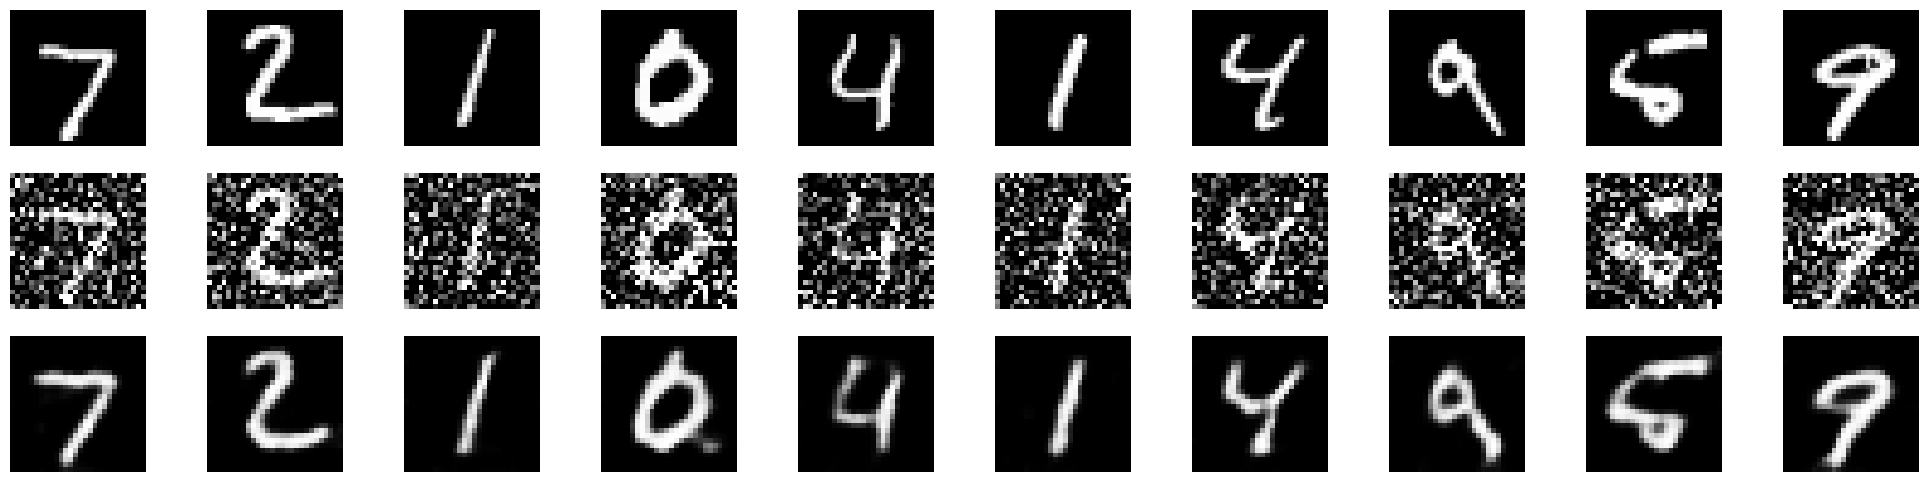

In [ ]:
# Add noise to the test images
noisy_imgs = images + noise_factor * torch.randn_like(images)  # Add random noise
noisy_imgs = torch.clamp(noisy_imgs, 0., 1.)  # Keep pixel values between 0 and 1

# Pass noisy images through the model
output = model(noisy_imgs)

# Detach tensors and move to CPU for plotting
original_imgs = images.cpu().detach()
noisy_imgs = noisy_imgs.cpu().detach()
output = output.cpu().detach()

# Reshape the output to match image dimensions (e.g., 28x28)
output = output.view(batch_size, 1, 28, 28) # Output is resized into a batch of images

# Plot the first ten original, noisy, and reconstructed images
fig, axes = plt.subplots(nrows=3, ncols=10, sharex=True, sharey=True, figsize=(25, 6))

# Top row: Original images, Middle row: Noisy images, Bottom row: Reconstructed images
for img_set, row in zip([original_imgs[:10], noisy_imgs[:10], output[:10]], axes):
    for img, ax in zip(img_set, row):
        ax.imshow(img.squeeze(), cmap='gray')
        ax.axis('off')

plt.show()